In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

In [2]:
INPUT_TRAIN = '../input/train.csv'
INPUT_TEST = '../input/test.csv'
OUTPUT_SUBMIT = '../output/submit.csv'

In [3]:
def calculation_distance(x_1, y_1, x_2, y_2):
    # 赤道半径 (km)
    R = 6371
    # Radian角に変換
    _x1, _y1, _x2, _y2  = map(np.radians, [x_1, y_1, x_2, y_2])
    
    delta_x = _x2 - _x1
    delta_y = _y2 - _y1
    
    # 距離を計算
    a = np.sin(delta_y/2.0)**2 + np.cos(_y1) * np.cos(_y2) * np.sin(delta_x/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def calculation_azimuth(x_1, y_1, x_2, y_2):
    # Radian角に修正
    _x1, _y1, _x2, _y2 = map(np.radians, [x_1, y_1, x_2, y_2])
    
    delta_x = _x2 - _x1
    _y = np.sin(delta_x)
    _x = np.cos(_y1) * np.tan(_y2) - np.sin(_y1) * np.cos(delta_x)

    psi = np.rad2deg(np.arctan2(_y, _x))
    
    return np.where(psi < 0, 360 + psi, psi)

def outlier_iqr(df, columns=None):
    if columns == None:
        columns = df.columns

    for col in columns:
        q1 = df[col].describe()['25%']
        q3 = df[col].describe()['75%']
        #四分位範囲
        iqr = q3 - q1 
        
        outlier_min = q1 - iqr * 1.5
        outlier_max = q3 + iqr * 1.5

        df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
        
    return df

In [4]:
def preprocessing(df, isTrainData=True):
    print('before dropna:{}'.format(df.shape))
    df = df.dropna()
    print('after dropna:{}'.format(df.shape))
    
    # fare_amount
    if 'fare_amount' in df.columns:
        df = df[df['fare_amount'] > 0]
        print('after fare_amount > 0:{}'.format(df.shape))

        df = outlier_iqr(df, columns=['fare_amount'])
        print('after outlier_iqr:{}'.format(df.shape))
    
    # latitude and longitude
    if isTrainData:
        df = df[(df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73)]
        df = df[(df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)]
        df = df[(df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -73)]
        df = df[(df['dropoff_latitude'] > 40) & (df['dropoff_latitude'] < 42)]
        print('after narrrowing location:{}'.format(df.shape))
    
    # passenger count
    df = df[df['passenger_count'] > 0]
    print('after passenger count > 0:{}'.format(df.shape))
    
    # add new feature from latitude and longitude
    df['distance'] = calculation_distance(df['pickup_longitude'],
                                      df['pickup_latitude'],
                                      df['dropoff_longitude'],
                                      df['dropoff_latitude'])
    df['azimuth'] = calculation_azimuth(df['pickup_longitude'],
                                      df['pickup_latitude'],
                                      df['dropoff_longitude'],
                                      df['dropoff_latitude'])
    print('after adding distance and azimuth > 0:{}'.format(df.shape))
    
    # modify pickup_datetime
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')
    
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
    df['year'] = df['pickup_datetime'].dt.year
    print('after updating pickup_datetime > 0:{}'.format(df.shape))
    
    return df

# Load Test Data

In [5]:
df_test = pd.read_csv(INPUT_TEST)
df_test = preprocessing(df_test, isTrainData=False)
df_test.head()

before dropna:(9914, 7)
after dropna:(9914, 7)
after passenger count > 0:(9914, 7)
after adding distance and azimuth > 0:(9914, 9)
after updating pickup_datetime > 0:(9914, 14)


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,azimuth,hour,day,month,dayofweek,year
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2.323260,197.102591,13,27,1,1,2015
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,335.311613,13,27,1,1,2015
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,156.994148,11,8,10,5,2011
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,203.513308,21,1,12,5,2012
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,200.618451,21,1,12,5,2012


# Load Train Data

In [6]:
df_train = pd.read_csv(INPUT_TRAIN, nrows=5500) # TODO ふやす
df_train = preprocessing(df_train, isTrainData=True)
df_train.head()

before dropna:(5500, 8)
after dropna:(5500, 8)
after fare_amount > 0:(5498, 8)
after outlier_iqr:(5029, 8)
after narrrowing location:(4925, 8)
after passenger count > 0:(4907, 8)
after adding distance and azimuth > 0:(4907, 10)
after updating pickup_datetime > 0:(4907, 15)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,azimuth,hour,day,month,dayofweek,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,167.240469,17,15,6,0,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,21.498365,16,5,1,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,211.033211,0,18,8,3,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,352.327836,4,21,4,5,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,28.802783,7,9,3,1,2010


# Modeling

In [7]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [8]:
X = df_train.drop(columns=['key', 'fare_amount', 'pickup_datetime'])
y = df_train['fare_amount']

print(X.shape)
print(y.shape)

(4907, 12)
(4907,)


In [9]:
X_pred = df_test.drop(columns=['key','pickup_datetime'])
print(X_pred.shape)

(9914, 12)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3925, 12)
(982, 12)
(3925,)
(982,)


In [19]:
params = {
    'silent' : 1,
    'max_depth' : 6,
    'min_child_weight' : 1,
    'eta' : 0.1,
    'tree_method' : 'exact',
    'objective' : 'reg:linear',
    'eval_metric' : 'rmse',
    'predictor' : 'cpu_predictor'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# hyper parameter turning

In [12]:
gridsearch_params = [
    (max_depth, eta)
    for max_depth in [6,7, 8]
    for eta in [0.1, 0.05, 0.01]
]
gridsearch_params

[(6, 0.1),
 (6, 0.05),
 (6, 0.01),
 (7, 0.1),
 (7, 0.05),
 (7, 0.01),
 (8, 0.1),
 (8, 0.05),
 (8, 0.01)]

In [13]:
min_rmse = float('inf')
best_param = []

for max_depth, eta in gridsearch_params:
    print('max_depth={}, eta={}'.format(max_depth, eta))
    
    params['max_depth'] = max_depth
    params['eta'] = eta
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=100, # TODO: 1000 にする
        seed=0,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=5
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].idxmin()
    print('  RMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
    
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_param = (max_depth, eta)
        
print('\nBest parmas {}, RMSE {}'.format(best_param, min_rmse))

max_depth=6, eta=0.1
  RMSE 1.9716552 for 99 rounds
max_depth=6, eta=0.05
  RMSE 1.9895973999999998 for 99 rounds
max_depth=6, eta=0.01
  RMSE 4.0105716000000005 for 99 rounds
max_depth=7, eta=0.1
  RMSE 2.0067282 for 89 rounds
max_depth=7, eta=0.05
  RMSE 2.0053444 for 99 rounds
max_depth=7, eta=0.01
  RMSE 4.023728800000001 for 99 rounds
max_depth=8, eta=0.1
  RMSE 2.030862 for 89 rounds
max_depth=8, eta=0.05
  RMSE 2.0435786 for 99 rounds
max_depth=8, eta=0.01
  RMSE 4.0390543999999995 for 99 rounds

Best parmas (6, 0.1), RMSE 1.9716552


In [14]:
# learning again by best params
params['max_depth'] = best_param[0]
params['eta'] = best_param[1]

model = xgb.train(params=params,
                 dtrain=dtrain,
                 num_boost_round=1000,
                 early_stopping_rounds=5,
                 evals=[(dtest, 'test')])

[0]	test-rmse:8.52693
Will train until test-rmse hasn't improved in 5 rounds.
[1]	test-rmse:7.74526
[2]	test-rmse:7.04625
[3]	test-rmse:6.42359
[4]	test-rmse:5.86927
[5]	test-rmse:5.37025
[6]	test-rmse:4.93316
[7]	test-rmse:4.54215
[8]	test-rmse:4.19679
[9]	test-rmse:3.89288
[10]	test-rmse:3.62402
[11]	test-rmse:3.40315
[12]	test-rmse:3.203
[13]	test-rmse:3.02582
[14]	test-rmse:2.87819
[15]	test-rmse:2.75407
[16]	test-rmse:2.63837
[17]	test-rmse:2.53933
[18]	test-rmse:2.45177
[19]	test-rmse:2.38573
[20]	test-rmse:2.32618
[21]	test-rmse:2.28037
[22]	test-rmse:2.23881
[23]	test-rmse:2.20311
[24]	test-rmse:2.17793
[25]	test-rmse:2.15131
[26]	test-rmse:2.13459
[27]	test-rmse:2.11212
[28]	test-rmse:2.09614
[29]	test-rmse:2.08517
[30]	test-rmse:2.07588
[31]	test-rmse:2.06219
[32]	test-rmse:2.0552
[33]	test-rmse:2.0499
[34]	test-rmse:2.04275
[35]	test-rmse:2.03546
[36]	test-rmse:2.0329
[37]	test-rmse:2.02949
[38]	test-rmse:2.02469
[39]	test-rmse:2.02034
[40]	test-rmse:2.01936
[41]	test-rmse:2

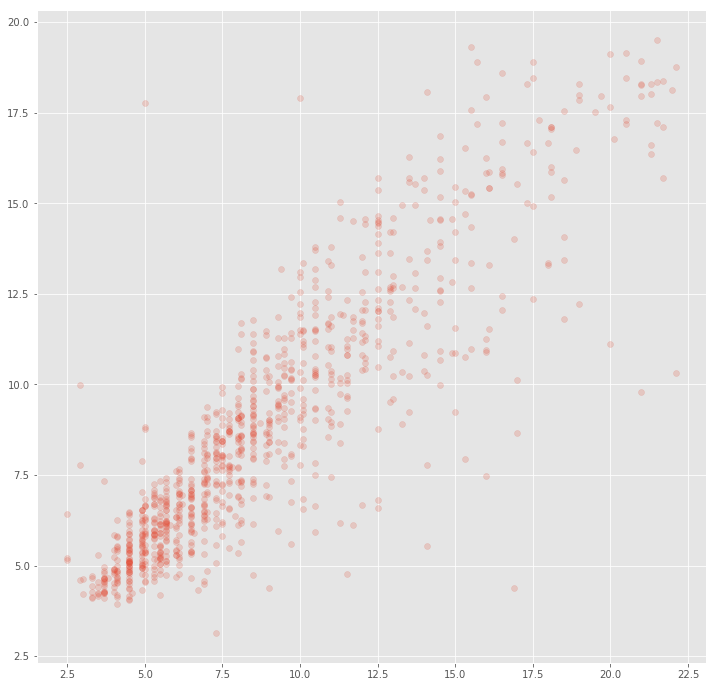

In [15]:
# prediction
prediction = model.predict(xgb.DMatrix(X_test),
                                        ntree_limit=model.best_ntree_limit)
plt.figure(figsize=(12,12))
plt.scatter(y_test[:1000], prediction[:1000], alpha=0.2)
plt.show()

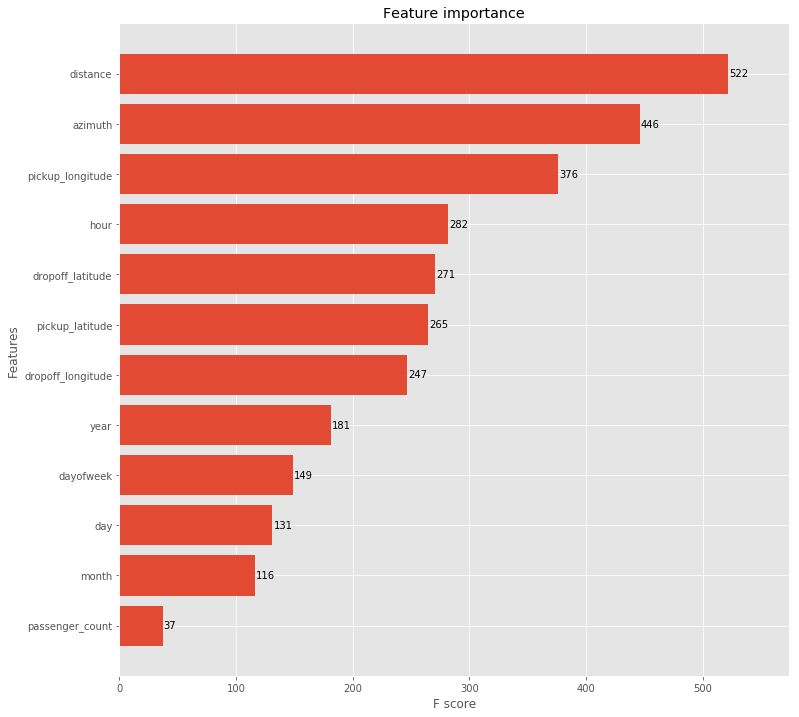

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=12, height=0.8, ax=ax)
plt.show()

In [17]:
pred = model.predict(xgb.DMatrix(X_pred),
                     ntree_limit=model.best_ntree_limit)
print(pred.shape)

(9914,)


In [18]:
df_test['fare_amount'] = pred
df_test[['key','fare_amount']].to_csv(OUTPUT_SUBMIT, index=False)